In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from konlpy.tag import Mecab
from collections import Counter
import re

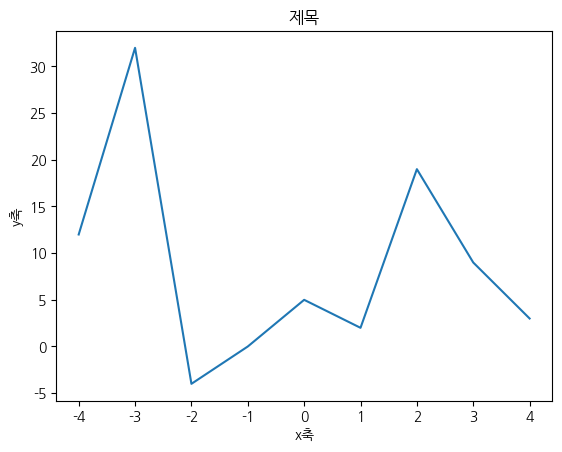

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

plt.plot([-4, -3, -2, -1, 0, 1, 2, 3, 4], [12, 32, -4, 0, 5, 2, 19, 9, 3])
plt.xlabel('x축')
plt.ylabel('y축')
plt.title('제목')
plt.show()

In [3]:
# 유튜브 채널의 영상을 STT로 변환한 영상텍스트 데이터 적재
video_text_data = pd.read_csv('youtube_channel_video_text_data.csv')

In [4]:
# 데이터 확인
print(video_text_data.head())

  채널구분                      채널ID              제목       개설 날짜        구독자  \
0    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
1    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
2    A  UCMFk5S7g5DY-CZNVh_Kyz_A  약사가 들려주는 약 이야기  2017-03-02  1,780,000   
3    B  UC3iSLVH0MxHfwO69oHKpvog            리틀약사  2015-02-16    454,000   
4    B  UC3iSLVH0MxHfwO69oHKpvog            리틀약사  2015-02-16    454,000   

          영상ID                                            대표영상텍스트  
0  rFzEHqZTt8w   우리 집에다가 무신코나든 생활용품들이 건강을 망칠 수가 있습니다. 아무리 유발하고...  
1  q4RDfkw177Y   주방은 우리 가족의 먹거리는 데단이 중요한 것이죠. 그런데 주방에서 사용하는 물건...  
2  1a6s-lpMxdc   커피를 건강하게 마시지 못하면 고지열증, 고콜렛스테로 열정이 생기고 당뇨병이 생기...  
3  rDIFXZD6TN8   밥할 때 넣으면 좋은 것 3가지. 첫 번째 소주. 현미밥 1인분을 할 때 소주 2...  
4  hxJLOR9e7Nw   누룽지와 숙룡 이런 분들 절대 먹지 마세요. 답소 날뢰쪽 온도가 220에서 250...  


In [5]:
video_text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   채널구분     15 non-null     object
 1   채널ID     15 non-null     object
 2   제목       15 non-null     object
 3   개설 날짜    15 non-null     object
 4   구독자      15 non-null     object
 5   영상ID     15 non-null     object
 6   대표영상텍스트  15 non-null     object
dtypes: object(7)
memory usage: 972.0+ bytes


In [6]:
# 한국어 불용어 리스트
stop_words = set([
    '이', '그', '저', '것', '수', '것을', '그리고', '더', '더욱', '너무', '정말', '진짜', '이제', '다시', '이런', '저런', '그런', '또', '또는',
    '하지만', '그러나', '그래도', '반면에', '이외에', '이렇게', '저렇게', '여기', '저기', '이것', '저것', '여러', '여러분', '너', '나', '우리',
    '당신', '어떤', '어느', '무엇', '누구', '모두', '많은', '좋은', '아주', '매우', '너무', '정말', '진짜', '자주', '항상', '가장', '크게', '작게',
    '게', '거'
])

# 추가 불용어 정의
custom_stop_words = set([
    '안녕하세요', '감사합니다', '잘', '다시', '정말', '이것', '그것', '그리고', '그러나', '하지만', 
    '해서', '하는', '같은', '이런', '저런', '그런', '할', '있는', '없는', '있는지', '없는지', '시청', '감사', '생각',
    '양과자', '선생'
])

# 불용어 리스트 합치기
stop_words.update(custom_stop_words)  # 또는 stop_words = stop_words | custom_stop_words

# 통합된 불용어 리스트 확인
print(stop_words)


{'누구', '매우', '다시', '더', '나', '모두', '저기', '여기', '이외에', '그런', '해서', '할', '잘', '또는', '반면에', '선생', '안녕하세요', '것을', '무엇', '같은', '게', '너무', '것', '이제', '또', '감사합니다', '어떤', '당신', '아주', '하지만', '하는', '그것', '그래도', '어느', '그리고', '시청', '이', '생각', '이것', '많은', '항상', '없는', '그러나', '수', '감사', '더욱', '우리', '작게', '가장', '저렇게', '이런', '저', '양과자', '너', '여러', '정말', '저것', '좋은', '진짜', '크게', '있는지', '있는', '없는지', '저런', '거', '그', '여러분', '자주', '이렇게'}


In [7]:
# 확장된 영양제 및 관련 키워드 목록 정의
nutrient_keywords = set([
    # 영양제 및 건강보조식품
    '비타민', '칼슘', '오메가3', '프로바이오틱스', '철분', '마그네슘', '아연', '비타민A', '비타민B', '비타민C', '비타민D', '비타민E', '엽산',
    '멜라토닌', '베르베린', '유산균', '단백질', '아미노산', '콜라겐', '코엔자임Q10', '글루타민', '알로에', '홍삼', '녹용', '스피루리나', '클로렐라', 
    '히알루론산', '글루코사민', '로얄젤리', '프로폴리스', '오메가-3', '유산균', '밀크씨슬', '루테인', 'EPA', 'DHA', '크릴오일', '코큐텐', 
    '아르기닌', '타우린', '피쉬오일', '피부영양제', '머리영양제', '헤어영양제', '비오틴', '피쉬콜라겐', '고지혈증', '콜레스테롤', '당뇨병',
    
    # 질병
    '면역', '피로', '피곤', '수면', '스트레스', '소화', '혈압', '당뇨', '콜레스테롤', '간', '간건강', '심장', '장', '장건강', 
    '알레르기', '감기', '독감', '빈혈', '치매', '우울증', '불안증', '폐렴', '천식', '관절염', '골다공증', '비만', '다이어트', '체중감량', 
    '피부질환', '아토피', '습진', '건선', '백반증', '자가면역질환', '천식', '기관지염', '천식',
    
    # 신체 부위
    '관절', '뼈', '눈', '피부', '탈모', '간', '심장', '장', '위', '신장', '폐', '두뇌', '척추', '근육', '대장', '소장', '방광', 
    '전립선', '갑상선', '귀', '코', '목', '발', '팔', '다리', '발목', '손목', '발가락', '손가락', '이마', '턱', '목', '등', 
    '허리', '배', '속', '가슴', '폐', '갈비뼈', '갈비뼈', '어깨', '목', '머리', '머릿결', '피부결',
    
    # 증상
    '소화불량', '변비', '설사', '복통', '두통', '어지럼증', '피부건조', '여드름', '탈모', '부종', '수족냉증', '불면증', '과민성대장증후군', 
    '속쓰림', '메스꺼움', '구토', '기침', '가래', '가슴답답함', '숨가쁨', '피로감', '무기력', '무기력증', '피부염', '소양증', '소화장애', 
    '식욕부진', '구역질', '경련', '발작', '호흡곤란', '가래', '가슴통증', '흉통', '수면장애', '피부발진', '진드기', '벌레물림', '가려움증', 
    '아픔', '통증', '피부붉어짐', '화끈거림', '발열', '오한', '근육통', '관절통', '허리통증', '요통', '등통증', '목통증', '어깨통증', 
    '팔통증', '다리통증', '발통증', '발목통증', '손목통증', '발가락통증', '손가락통증', '이마통증', '턱통증', '목통증', '속쓰림',
    
    # 추가 키워드
    '항산화', '항염', '항바이러스', '항균', '항진균', '디톡스', '해독', '활력', '에너지', '체력증강', '근력증가', '신진대사', '대사증후군',
    '면역력', '면역강화', '피로회복', '혈액순환', '혈류', '혈관', '심혈관', '폐활량', '근력강화', '유산소운동', '근력운동', '헬스', 
    '피트니스', '근육량', '근지구력', '체지방', '근비대', '근육성장', '근육회복', '운동', '운동효과', '운동방법', '운동계획', '운동프로그램', 
    '운동루틴', '운동기구', '운동기법', '운동습관', '운동요법', '운동처방', '운동능력', '운동자세', '운동부위', '운동종목', '운동시간', 
    '운동강도', '운동빈도', '운동량', '운동지속시간', '운동지속', '운동패턴', '운동기록', '운동성향', '운동습관', '운동계획', '운동법', 
    '운동기법', '운동량', '운동기구', '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말', '운동용품', '운동기구', 
    '운동용품', '운동복', '운동화', '운동신발', '운동모자', '운동장갑', '운동양말'
])


In [8]:
# Mecab 초기화
mecab = Mecab()

# 텍스트 전처리 함수
def preprocess_text(text):
    tokens = mecab.morphs(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# 워드 클라우드 생성 및 시각화 함수
def generate_word_cloud(text, title):
       
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # 한글 폰트 경로
        colormap='viridis'
    ).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()



In [9]:
# 'video_text_data' 데이터에 대해 동일한 절차로 키워드 추출

# 각 채널 ID별로 '대표영상텍스트'를 전처리하여 'nouns'와 'nouns_str' 컬럼 추가
grouped_video_text_data = video_text_data.groupby(['채널구분', '채널ID'])['대표영상텍스트'].apply(lambda x: ' '.join(x.dropna())).reset_index()
grouped_video_text_data['nouns'] = grouped_video_text_data['대표영상텍스트'].apply(preprocess_text)
grouped_video_text_data['nouns_str'] = grouped_video_text_data['nouns'].apply(' '.join)

In [10]:
# TF-IDF 벡터라이저를 사용하여 각 채널의 명사에 대해 TF-IDF 계산
tfidf_vectorizer_video = TfidfVectorizer(vocabulary=nutrient_keywords)
tfidf_matrix_video = tfidf_vectorizer_video.fit_transform(grouped_video_text_data['nouns_str'])

# TF-IDF 결과를 데이터프레임으로 변환
tfidf_df_video = pd.DataFrame(tfidf_matrix_video.toarray(), index=grouped_video_text_data['채널구분'], columns=tfidf_vectorizer_video.get_feature_names_out())


/home/samuel/aSSIST/aSSIST_DM1/venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:1366: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [11]:
tfidf_df_video

,DHA,EPA,가래,가려움증,가슴,가슴답답함,가슴통증,간,간건강,갈비뼈,...,혈관,혈류,혈압,혈액순환,호흡곤란,홍삼,화끈거림,활력,흉통,히알루론산
채널구분,,,,,,,,,,,,,,,,,,,,,
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.095717
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.029093,0.0,0.029093,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [12]:
grouped_video_text_data

,채널구분,채널ID,대표영상텍스트,nouns,nouns_str
0,A,UCMFk5S7g5DY-CZNVh_Kyz_A,우리 집에다가 무신코나든 생활용품들이 건강을 망칠 수가 있습니다. 아무리 유발하고...,"[집, 에다가, 무신, 코, 든, 생활, 용품, 들, 건강, 을, 망칠, 가, 있,...",집 에다가 무신 코 든 생활 용품 들 건강 을 망칠 가 있 습니다 . 아무리 유발 ...
1,B,UC3iSLVH0MxHfwO69oHKpvog,밥할 때 넣으면 좋은 것 3가지. 첫 번째 소주. 현미밥 1인분을 할 때 소주 2...,"[밥, 때, 넣, 으면, 좋, 은, 3, 가지, ., 첫, 번, 째, 소주, ., ...",밥 때 넣 으면 좋 은 3 가지 . 첫 번 째 소주 . 현미밥 1 인분 을 때 소주...
2,C,UCY-mXLM6DsS9cmSwlh0tqSA,먼저 분말을 그대로 이용하시는 분들을 위한 제품을 먼저 추천 드리자면 1등은 안녕...,"[먼저, 분말, 을, 그대로, 이용, 하, 시, 는, 분, 들, 을, 위한, 제품,...",먼저 분말 을 그대로 이용 하 시 는 분 들 을 위한 제품 을 먼저 추천 드리 자면...
3,D,UC6ggXTuBVchhwHeQ12Ita1w,오늘 영상에서는 좋은 소식을 하나 전해드릴 텐데요. 이런 문제들을 보다 부드럽게 ...,"[오늘, 영상, 에서, 는, 좋, 은, 소식, 을, 하나, 전해, 드릴, 텐데요, ...",오늘 영상 에서 는 좋 은 소식 을 하나 전해 드릴 텐데요 . 문제 들 을 보다 부...
4,E,UCCMFTDGarjgZLc1DlIbbvRg,고시얼증 약도 호럼약처럼 한 번 먹으면 계속 먹어야 된다 이렇게 알고 계신 분들이...,"[고시, 얼, 증, 약도, 호, 럼, 약, 처럼, 한, 번, 먹, 으면, 계속, 먹...",고시 얼 증 약도 호 럼 약 처럼 한 번 먹 으면 계속 먹 어야 된다 알 고 계신 ...


In [15]:
# grouped_video_text_data['대표영상텍스트']
file_path = './grouped_video_text_data.csv'
grouped_video_text_data[['채널구분','대표영상텍스트']].to_csv(file_path, index=False, encoding='utf-8-sig')

In [16]:
import numpy as np
top_n = 230
top_keywords_video = {}

for channel_id in grouped_video_text_data['채널구분']:
    sorted_indices = np.argsort(tfidf_df_video.loc[channel_id])[::-1]
    top_keywords_video[channel_id] = tfidf_df_video.columns[sorted_indices][:top_n]

# 키워드 결과를 데이터프레임으로 변환
top_keywords_df_video = pd.DataFrame(top_keywords_video).T
top_keywords_df_video.columns = [f'Keyword_{i+1}' for i in range(top_n)]

# 결과 확인
print(top_keywords_df_video)



  Keyword_1 Keyword_2 Keyword_3 Keyword_4 Keyword_5 Keyword_6 Keyword_7  \
A        신장        피부        치매        피곤      다이어트       아토피       불안증   
B        소화       단백질        통증      화끈거림        홍삼      호흡곤란      혈액순환   
C       콜라겐       비타민       유산균      알레르기        대장        칼슘        피부   
D       전립선        아연        설사      어지럼증      스트레스        혈압        혈관   
E        관절        운동        근육       관절염       손가락        통증      혈액순환   

  Keyword_8 Keyword_9 Keyword_10  ... Keyword_221 Keyword_222 Keyword_223  \
A       당뇨병       에너지         수면  ...           귀          구토         구역질   
B        혈압        혈류         혈관  ...           귀          구토         구역질   
C        운동       에너지        비오틴  ...        근력강화          구토           귀   
D        신장        변비         근육  ...           귀          구토         구역질   
E      화끈거림        홍삼       호흡곤란  ...        근력증가        근력강화           귀   

  Keyword_224 Keyword_225 Keyword_226 Keyword_227 Keyword_228 Keyword_229  \
A        